In [1]:
%matplotlib inline

from pssm.dglm import NormalDLM, PoissonDLM, BinomialDLM, CompositeDLM
from pssm.structure import UnivariateStructure, MultivariateStructure
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =(12,4)
np.random.seed(42)

# Dynamic Generalised Linear Models

## Dynamic Linear Models

Dynamic linear models are a specific instance of state-space models where the observation and states are defined by

\begin{aligned}
Y_t|\theta_t,\Phi_t &\sim \mathcal{N}\left(\theta_t; \mathsf{F}^T\theta_{t}, V\right) \\
\theta_t|\theta_{t-1},\Phi_t &\sim \mathcal{N}\left(\theta_t;\mathsf{G}\theta_{t-1}, \mathsf{W}\right)
\end{aligned}

### Locally constant

The _locally constant_ DLM corresponds to a simple state random walk, where the structure is defined by

\begin{aligned}
\mathsf{F} &= \begin{bmatrix}1\end{bmatrix} \\
\mathsf{G} &= \begin{bmatrix}1\end{bmatrix}
\end{aligned}

This can be specified by using (in this case with a state variance of $\tau^2=3.4$):

In [2]:
lc = {'structure': UnivariateStructure.locally_constant(3.4)}
print("F = {}, G = {}".format(lc['structure'].F, lc['structure'].G))

F = [[1]], G = [[1]]


We can then instantiate a DLM (with observation variance $\sigma^2=1.4$):

In [3]:
ndlm = NormalDLM(structure=lc['structure'], V=1.4)

Assuming we have a state prior of

$$\theta_0 \sim \mathcal{N}\left(0, 1\right)$$

we can then generate the states $\theta_{1:T}$ and observation $y_{1:T}$:

In [4]:
# the initial state prior
m0 = np.array([0])
C0 = np.matrix([[1]])
state0 = mvn(m0, C0).rvs()

lc['states'] = [state0]

for t in range(1, 100):
    lc['states'].append(ndlm.state(lc['states'][t-1]))
    
lc['obs'] = [None]
for t in range(1, 100):
    lc['obs'].append(ndlm.observation(lc['states'][t]))

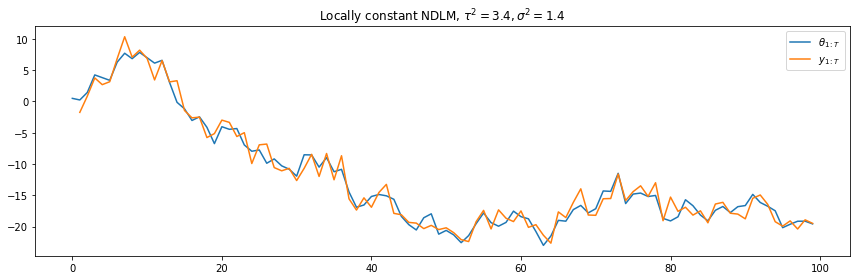

In [6]:
t = range(100)
plt.plot(t, lc['states'])
plt.plot(t, lc['obs'])
plt.legend([r"$\theta_{1:T}$", r"$y_{1:T}$"], loc=1)
plt.title(r"Locally constant NDLM, $\tau^2=3.4, \sigma^2=1.4$")
plt.tight_layout()
plt.show()

### Locally linear

A _locally linear_ structure incorporates both an underlying mean and a trend. In this case the structure corresponds to

$$
\mathsf{F}=\begin{bmatrix}1 & 0\end{bmatrix}, \qquad \mathsf{G}=\begin{bmatrix}1 & 1 \\ 1 & 0 \end{bmatrix}.
$$

If we assume a state covariance of

$$
\mathsf{W}=\begin{bmatrix}0.1 & 0 \\ 0 & 0.1 \end{bmatrix}
$$

we can create the structure as:

In [32]:
ll = {'structure': UnivariateStructure.locally_linear(W=np.matrix([[0.1, 0], [0, 0.1]]))}

and the Normal DLM structure can be created (with a state variance of $\sigma^2=2.5$) using:

In [33]:
ndlm = NormalDLM(structure=ll['structure'], V=2.5)

In this case we will assume a state prior of
$$
\theta_0 \sim \mathcal{N}\left(\begin{bmatrix}0 & -1\end{bmatrix}, \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$
and we can generate the states and observations as:

In [34]:
# the initial state prior
m0 = np.array([0, -1])
C0 = np.identity(2)
state0 = mvn(m0, C0).rvs()

ll['states'] = [state0]

for t in range(1, 100):
    ll['states'].append(ndlm.state(ll['states'][t-1]))
    
ll['obs'] = [None]
for t in range(1, 100):
    ll['obs'].append(ndlm.observation(ll['states'][t]))

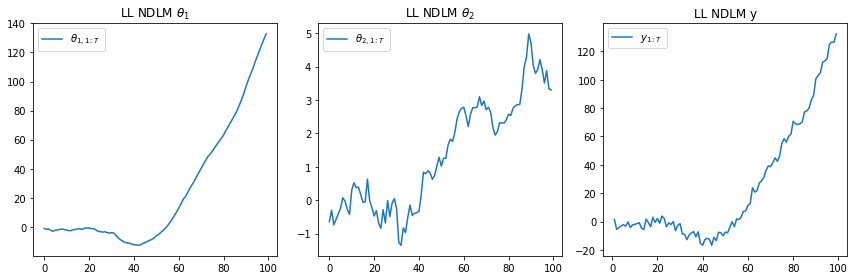

In [10]:
import matplotlib.pyplot as plt
t=range(100)
plt.subplot(1, 3, 1)
plt.plot(t, [state[0] for state in ll['states']])
plt.legend([r"$\theta_{1,1:T}$"], loc=0)
plt.title(r"LL NDLM $\theta_1$")
plt.subplot(1, 3, 2)
plt.plot(t, [state[1] for state in ll['states']])
plt.legend([r"$\theta_{2,1:T}$"], loc=0)
plt.title(r"LL NDLM $\theta_2$")
plt.subplot(1, 3, 3)
plt.plot(range(100), ll['obs'])
plt.legend([r"$y_{1:T}$"], loc=0)
plt.title(r"LL NDLM y")
plt.tight_layout()

### Fourier seasonality

In [11]:
fourier = {'structure': UnivariateStructure.cyclic_fourier(period=10, harmonics=2, W=np.identity(4))}

In [12]:
print("F(fourier) = {}".format(fourier['structure'].F))
print("G(fourier) = {}".format(fourier['structure'].G))

F(fourier) = [[1.]
 [0.]
 [1.]
 [0.]]
G(fourier) = [[ 0.80901699  0.58778525  0.          0.        ]
 [-0.58778525  0.80901699  0.          0.        ]
 [ 0.          0.          0.30901699  0.95105652]
 [ 0.          0.         -0.95105652  0.30901699]]


In [13]:
ndlm_comp = NormalDLM(structure=(lc['structure']+fourier['structure']), V=2.5)
# the initial state prior
m0 = np.array([0, 0, 0, 0, 0])
C0 = np.identity(5)
state0 = np.random.multivariate_normal(m0, C0)

fourier['states'] = [state0]

for t in range(1, 100):
    fourier['states'].append(ndlm_comp.state(fourier['states'][t-1]))
    
fourier['obs'] = [None]
for t in range(1, 100):
    fourier['obs'].append(ndlm_comp.observation(fourier['states'][t]))

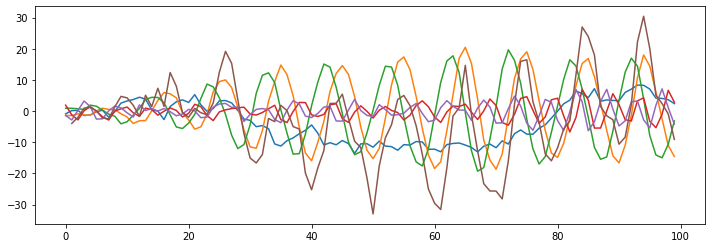

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(100), fourier['states'])
plt.plot(range(100), fourier['obs'])

### ARMA

#### ARMA(1)

##### Normal DLM

In [15]:
arma1 = {'structure': UnivariateStructure.arma(p=1, betas=[0.3], W=2.5)}

In [16]:
print("F(ARMA(1)) = {}".format(arma1['structure'].F))
print("G(ARMA(1)) = {}".format(arma1['structure'].G))
print("W(ARMA(1)) = {}".format(arma1['structure'].W))

F(ARMA(1)) = [[1.]]
G(ARMA(1)) = [[0.3]]
W(ARMA(1)) = [[2.5]]


In [17]:
# the initial state prior
m0 = np.array([0])
C0 = np.identity(1)
state0 = mvn(m0, C0).rvs()

ndlm_arma1 = NormalDLM(structure=(arma1['structure']), V=2.5)

arma1['states'] = [state0]

for t in range(1, 100):
    arma1['states'].append(ndlm_arma1.state(arma1['states'][t-1]))
    
arma1['obs'] = [None]
for t in range(1, 100):
    arma1['obs'].append(ndlm_arma1.observation(arma1['states'][t]))

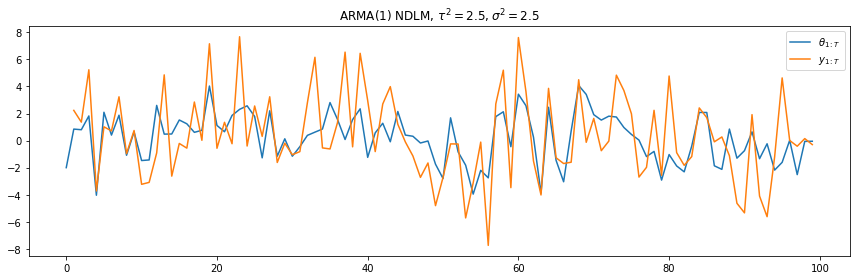

In [18]:
t = range(100)
plt.plot(t, arma1['states'])
plt.plot(t, arma1['obs'])
plt.legend([r"$\theta_{1:T}$", r"$y_{1:T}$"], loc=1)
plt.title(r"ARMA(1) NDLM, $\tau^2=2.5, \sigma^2=2.5$")
plt.tight_layout()

##### Poisson DLM

In [19]:
# the initial state prior
m0 = np.array([0])
C0 = np.identity(1)
state0 = mvn(m0, C0).rvs()

podlm_arma1 = PoissonDLM(structure=(arma1['structure']))

arma1['states'] = [state0]

for t in range(1, 100):
    arma1['states'].append(podlm_arma1.state(arma1['states'][t-1]))
    
arma1['obs'] = [None]
for t in range(1, 100):
    arma1['obs'].append(podlm_arma1.observation(arma1['states'][t]))

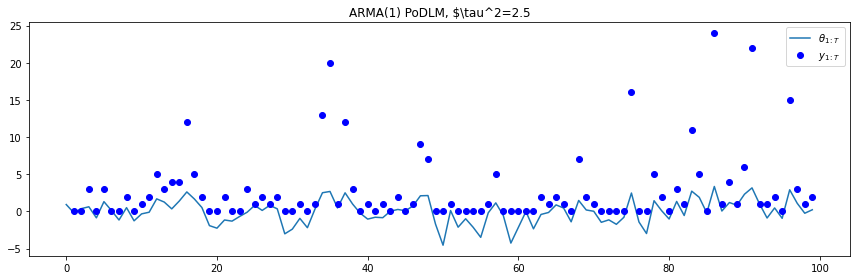

In [20]:
t = range(100)
plt.plot(t, arma1['states'])
plt.plot(t, arma1['obs'], 'bo')
plt.legend([r"$\theta_{1:T}$", r"$y_{1:T}$"], loc=1)
plt.title(r"ARMA(1) PoDLM, $\tau^2=2.5")
plt.tight_layout()

#### ARMA(2)

##### Normal DLM

In [21]:
arma2 = {'structure': UnivariateStructure.arma(p=2, betas=[0.3, 0.2], W=2.5)}

In [22]:
print("F(ARMA(2)) = {}".format(arma2['structure'].F))
print("G(ARMA(2)) = {}".format(arma2['structure'].G))
print("W(ARMA(2)) = {}".format(arma2['structure'].W))

F(ARMA(2)) = [[1.]
 [0.]]
G(ARMA(2)) = [[0.3 0.2]
 [1.  0. ]]
W(ARMA(2)) = [[2.5 0. ]
 [0.  0. ]]


In [23]:
# the initial state prior
m0 = np.array([0, 0])
C0 = np.identity(2)
state0 = mvn(m0, C0).rvs()

ndlm_arma2 = NormalDLM(structure=(arma2['structure']), V=2.5)

arma2['states'] = [state0]

for t in range(1, 100):
    arma2['states'].append(ndlm_arma2.state(arma2['states'][t-1]))
    
arma2['obs'] = [None]
for t in range(1, 100):
    arma2['obs'].append(ndlm_arma2.observation(arma2['states'][t]))

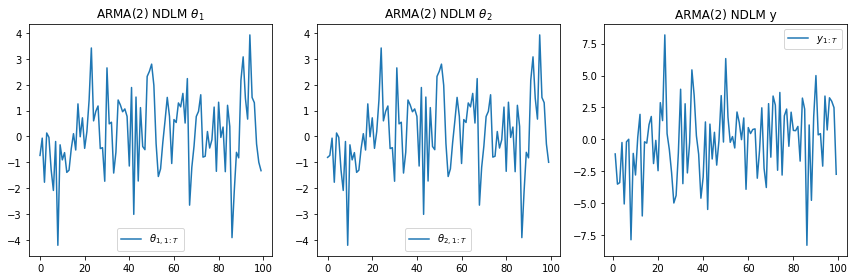

In [24]:
import matplotlib.pyplot as plt
t=range(100)
plt.subplot(1, 3, 1)
plt.plot(t, [state[0] for state in arma2['states']])
plt.legend([r"$\theta_{1,1:T}$"], loc=0)
plt.title(r"ARMA(2) NDLM $\theta_1$")
plt.subplot(1, 3, 2)
plt.plot(t, [state[1] for state in arma2['states']])
plt.legend([r"$\theta_{2,1:T}$"], loc=0)
plt.title(r"ARMA(2) NDLM $\theta_2$")
plt.subplot(1, 3, 3)
plt.plot(range(100), arma2['obs'])
plt.legend([r"$y_{1:T}$"], loc=0)
plt.title(r"ARMA(2) NDLM y")
plt.tight_layout()

##### Poisson DLM

In [25]:
# the initial state prior
m0 = np.array([0, 0])
C0 = np.identity(2)
state0 = mvn(m0, C0).rvs()

podlm_arma2 = PoissonDLM(structure=(arma2['structure']))

arma2['states'] = [state0]

for t in range(1, 100):
    arma2['states'].append(podlm_arma2.state(arma2['states'][t-1]))
    
arma2['obs'] = [None]
for t in range(1, 100):
    arma2['obs'].append(podlm_arma2.observation(arma2['states'][t]))

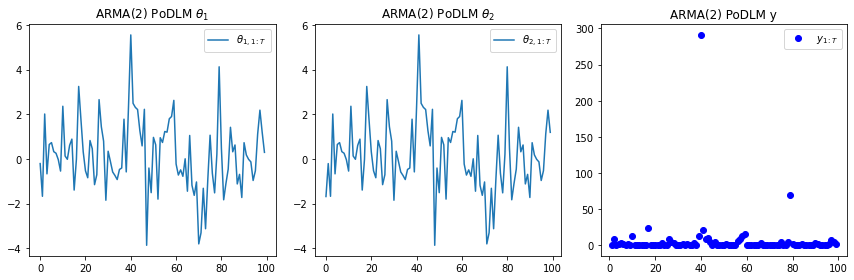

In [26]:
import matplotlib.pyplot as plt
t=range(100)
plt.subplot(1, 3, 1)
plt.plot(t, [state[0] for state in arma2['states']])
plt.legend([r"$\theta_{1,1:T}$"], loc=0)
plt.title(r"ARMA(2) PoDLM $\theta_1$")
plt.subplot(1, 3, 2)
plt.plot(t, [state[1] for state in arma2['states']])
plt.legend([r"$\theta_{2,1:T}$"], loc=0)
plt.title(r"ARMA(2) PoDLM $\theta_2$")
plt.subplot(1, 3, 3)
plt.plot(range(100), arma2['obs'], 'bo')
plt.legend([r"$y_{1:T}$"], loc=0)
plt.title(r"ARMA(2) PoDLM y")
plt.tight_layout()

### Filtering

#### Locally constant

In [27]:
from pssm.filters import KalmanFilter

kf = KalmanFilter(structure=lc['structure'], V=1.4)

m0 = np.array([0])
C0 = np.matrix([[1e3]])
filtered = {'ms': [m0], 'Cs': [C0]}

for t in range(1, 100):
    m, C = kf.filter(y=lc['obs'][t], m=filtered['ms'][t-1], C=filtered['Cs'][t-1])
    filtered['ms'].append(m)
    filtered['Cs'].append(C)

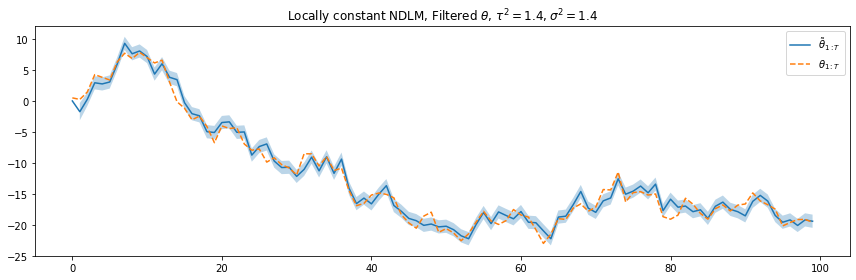

In [31]:
t = range(100)
plt.plot(t, filtered['ms'])
plt.plot(t, lc['states'], '--')
lb = []
ub = []
for m, C in zip(filtered['ms'], filtered['Cs']):
    lb.append((m[0] - C[0][0]).item())
    ub.append((m[0] + C[0][0]).item())
plt.fill_between(t[1:], lb[1:], ub[1:], alpha=0.3)
plt.legend([r"$\tilde{\theta}_{1:T}$", r"$\theta_{1:T}$"], loc=1)
plt.title(r"Locally constant NDLM, Filtered $\theta$, $\tau^2=1.4, \sigma^2=1.4$")
plt.tight_layout()
plt.show()

#### Locally linear

In [35]:
kf = KalmanFilter(structure=ll['structure'], V=2.5)

m0 = np.array([0, 0])
C0 = np.diag([1e3, 1e3])
filtered = {'ms': [m0], 'Cs': [C0]}

for t in range(1, 100):
    m, C = kf.filter(y=ll['obs'][t], m=filtered['ms'][t-1], C=filtered['Cs'][t-1])
    filtered['ms'].append(m)
    filtered['Cs'].append(C)

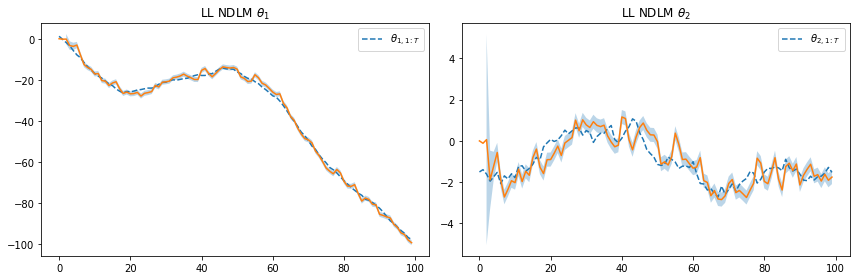

In [36]:
t=range(100)

lb = []
ub = []
for m, C in zip(filtered['ms'], filtered['Cs']):
    lb.append((m[0] - C.item((0,0)), m[1] - C.item((1,1)),))
    ub.append((m[0] + C.item((0,0)), m[1] + C.item((1,1)),))
    
plt.subplot(1, 2, 1)
plt.plot(t, [state[0] for state in ll['states']], '--')
plt.plot(t, [state[0] for state in filtered['ms']])
plt.fill_between(t[2:], [b[0] for b in lb[2:]], [b[0] for b in ub[2:]], alpha=0.3)
plt.legend([r"$\theta_{1,1:T}$"], loc=0)
plt.title(r"LL NDLM $\theta_1$")
plt.subplot(1, 2, 2)
plt.plot(t, [state[1] for state in ll['states']], '--')
plt.plot(t, [state[1] for state in filtered['ms']])
plt.fill_between(t[2:], [b[1] for b in lb[2:]], [b[1] for b in ub[2:]], alpha=0.3)
plt.legend([r"$\theta_{2,1:T}$"], loc=0)
plt.title(r"LL NDLM $\theta_2$")

plt.tight_layout()
plt.show()

### Parameter estimation (FFBS)

#### Locally constant

FFBS estimation for a locally constant model.

In [37]:
from pssm.mc import *

m0 = np.array([0])
C0 = np.identity(1)*1000

ffbs = FFBS(lc['structure'], m0, C0, 0.001, [0.001], lc['obs'])

Vs = [1]
Ws = [np.identity(1)]
states = []

for i in range(1, 20):
    W, V, _states = ffbs.run(V=Vs[i-1], W=Ws[i-1], states=True)
    Ws.append(W)
    Vs.append(V)
    states.append(_states)

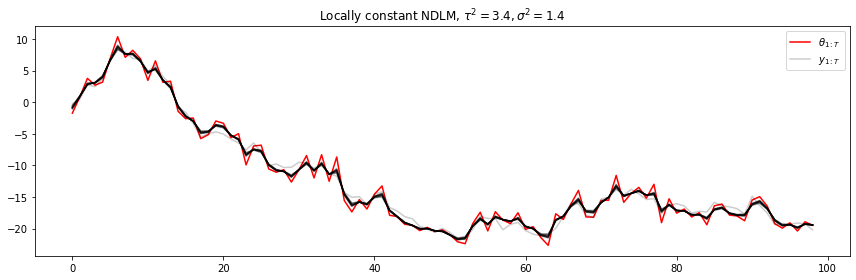

In [38]:
t = range(99)
plt.plot(t, lc['obs'][1:], c='red')
for i in range(19):
    plt.plot(t, states[i], c='black', alpha=0.2)
plt.legend([r"$\theta_{1:T}$", r"$y_{1:T}$"], loc=1)
plt.title(r"Locally constant NDLM, $\tau^2=3.4, \sigma^2=1.4$")
plt.tight_layout()

In [39]:
for i in range(20, 1000):
    W, V = ffbs.run(V=Vs[i-1], W=Ws[i-1], states=False)
    Ws.append(W)
    Vs.append(V)

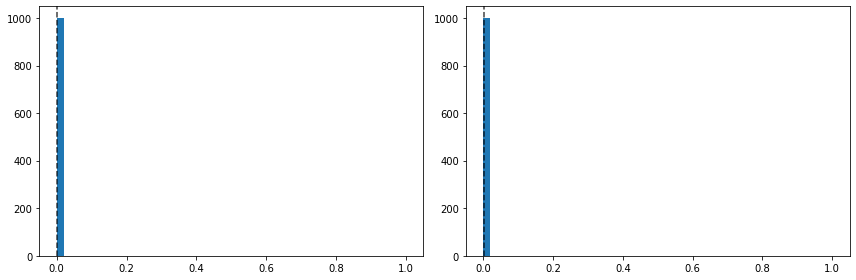

In [40]:
plt.subplot(1, 2, 1)
plt.hist(Vs, bins=50)
plt.axvline(x=np.mean(Vs), c='black', ls='--', alpha=0.75)
plt.subplot(1, 2, 2)
_Ws = [W[0][0] for W in Ws]
plt.hist(_Ws, bins=50)
plt.axvline(x=np.mean(_Ws), c='black', ls='--', alpha=0.75)
plt.tight_layout()

#### Locally linear



In [41]:
from pssm.mc import *

m0 = np.array([0, 0])
C0 = np.identity(2)*1000

ffbs = FFBS(ll['structure'], m0, C0, 1.0, [1.0, 1.0], ll['obs'])

Vs = [1]
Ws = [np.identity(2)]
states = []

for i in range(1, 20):
    W, V, _states = ffbs.run(V=Vs[i-1], W=Ws[i-1], states=True)
    Ws.append(W)
    Vs.append(V)
    states.append(_states)

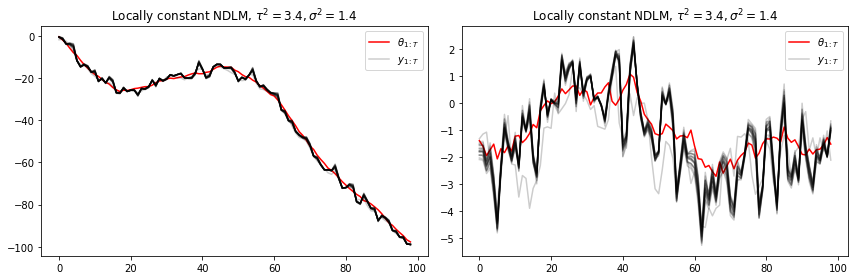

In [42]:
t = range(99)

plt.subplot(1, 2, 1)
plt.plot(t, [s[0] for s in ll['states'][1:]], c='red')
for i in range(19):
    plt.plot(t, [s[0] for s in states[i]], c='black', alpha=0.2)
plt.legend([r"$\theta_{1:T}$", r"$y_{1:T}$"], loc=1)
plt.title(r"Locally constant NDLM, $\tau^2=3.4, \sigma^2=1.4$")

plt.subplot(1, 2, 2)
plt.plot(t, [s[1] for s in ll['states'][1:]], c='red')
for i in range(19):
    plt.plot(t, [s[1] for s in states[i]], c='black', alpha=0.2)
plt.legend([r"$\theta_{1:T}$", r"$y_{1:T}$"], loc=1)
plt.title(r"Locally constant NDLM, $\tau^2=3.4, \sigma^2=1.4$")

plt.tight_layout()
plt.show()

In [43]:
for i in range(20, 1000):
    W, V = ffbs.run(V=Vs[i-1], W=Ws[i-1], states=False)
    Ws.append(W)
    Vs.append(V)

In [44]:
print("V (mean) = {}".format(np.mean(Vs)))
print("W1 (mean) = {}".format(np.mean([W[0][0] for W in Ws])))
print("W2 (mean) = {}".format(np.mean([W[1][1] for W in Ws])))

V (mean) = 0.0010276055935151277
W1 (mean) = 0.0010733552661955684
W2 (mean) = 0.0012855912948400196


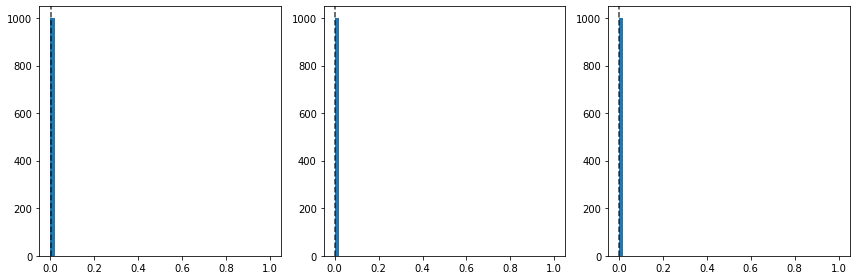

In [45]:
plt.subplot(1, 3, 1)
plt.hist(Vs, bins=50)
plt.axvline(x=np.mean(Vs), c='black', ls='--', alpha=0.75)
plt.subplot(1, 3, 2)
_Ws = [W[0][0] for W in Ws]
plt.hist(_Ws, bins=50)
plt.axvline(x=np.mean(_Ws), c='black', ls='--', alpha=0.75)
plt.subplot(1, 3, 3)
_Ws = [W[1][1] for W in Ws]
plt.hist(_Ws, bins=50)
plt.axvline(x=np.mean(_Ws), c='black', ls='--', alpha=0.75)
plt.tight_layout()
plt.show()

## Non-linear models

### Poisson DLM

In [46]:
plc = {'structure': UnivariateStructure.locally_constant(0.01)}
podlm = PoissonDLM(structure=plc['structure'])

In [47]:
# the initial state prior
m0 = np.array([0])
C0 = np.matrix([[1]])
state0 = mvn(m0, C0).rvs()

plc['states'] = [state0]

for t in range(1, 100):
    plc['states'].append(podlm.state(plc['states'][t-1]))
    
plc['obs'] = [None]
for t in range(1, 100):
    plc['obs'].append(podlm.observation(plc['states'][t]))

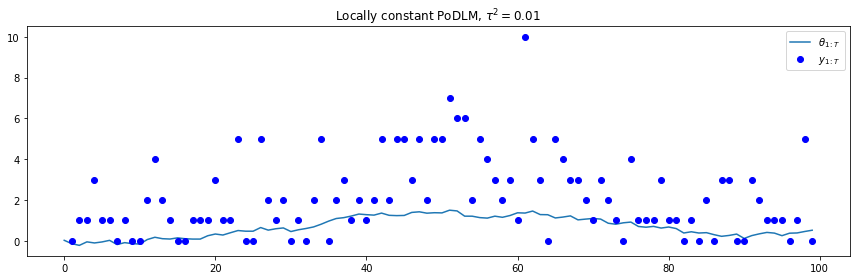

In [49]:
t = range(100)
plt.plot(t, plc['states'])
plt.plot(t, plc['obs'], 'bo')
plt.legend([r"$\theta_{1:T}$", r"$y_{1:T}$"], loc=1)
plt.title(r"Locally constant PoDLM, $\tau^2=0.01$")
plt.tight_layout()
plt.show()

### Binomial DLM

In [50]:
bdlm = BinomialDLM(structure=plc['structure'], categories=1)

In [51]:
# the initial state prior
m0 = np.array([0])
C0 = np.matrix([[1]])
state0 = mvn(m0, C0).rvs()

plc['states'] = [state0]

for t in range(1, 100):
    plc['states'].append(bdlm.state(plc['states'][t-1]))
    
plc['obs'] = [None]
for t in range(1, 100):
    plc['obs'].append(bdlm.observation(plc['states'][t]))

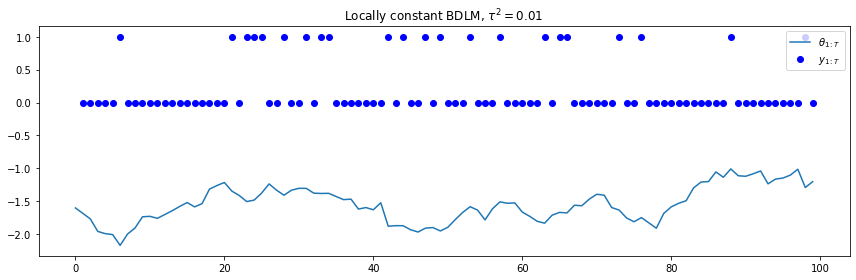

In [52]:
t = range(100)
plt.plot(t, plc['states'])
plt.plot(t, plc['obs'], 'bo')
plt.legend([r"$\theta_{1:T}$", r"$y_{1:T}$"], loc=1)
plt.title(r"Locally constant BDLM, $\tau^2=0.01$")
plt.tight_layout()

In [53]:
bdlm = BinomialDLM(structure=plc['structure'], categories=16)

In [54]:
# the initial state prior
m0 = np.array([0])
C0 = np.matrix([[5]])
state0 = mvn(m0, C0).rvs()

plc['states'] = [state0]

for t in range(1, 100):
    plc['states'].append(bdlm.state(plc['states'][t-1]))
    
plc['obs'] = [None]
for t in range(1, 100):
    plc['obs'].append(bdlm.observation(plc['states'][t]))

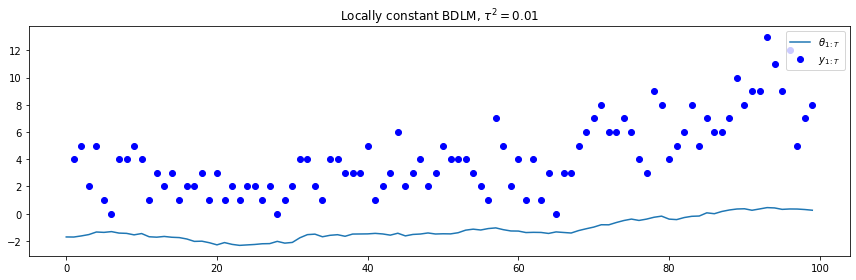

In [55]:
t = range(100)
plt.plot(t, plc['states'])
plt.plot(t, plc['obs'], 'bo')
plt.legend([r"$\theta_{1:T}$", r"$y_{1:T}$"], loc=1)
plt.title(r"Locally constant BDLM, $\tau^2=0.01$")
plt.tight_layout()

### Composite (multivariate) DGLMs

In [56]:
comp_lc = UnivariateStructure.locally_constant(W=0.3)
comp_seasonal = UnivariateStructure.cyclic_fourier(period=50, harmonics=2, W=np.eye(4))

comp_ndlm = NormalDLM(structure=comp_lc + comp_seasonal, V=2.3)
comp_bdlm = BinomialDLM(structure=comp_lc, categories=4)

composite = CompositeDLM(comp_ndlm, comp_bdlm)

In [57]:
# the initial state prior
m0 = np.array([0.0]*6)
C0 = np.eye(6)
state0 = mvn(m0, C0).rvs()

comp_states = [state0]

for t in range(1, 100):
    comp_states.append(composite.state(comp_states[t-1]))
    
comp_obs = [None]
for t in range(1, 100):
    comp_obs.append(composite.observation(comp_states[t]))

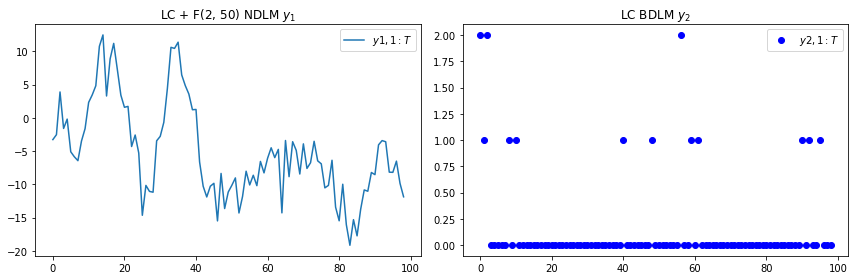

In [58]:
t=range(99)
plt.subplot(1, 2, 1)
plt.plot(t, [y[0] for y in comp_obs[1:]])
plt.legend([r"$y{1,1:T}$"], loc=0)
plt.title(r"LC + F(2, 50) NDLM $y_1$")
plt.subplot(1, 2, 2)
plt.plot(t, [y[1] for y in comp_obs[1:]], 'bo')
plt.legend([r"$y{2,1:T}$"], loc=0)
plt.title(r"LC BDLM $y_2$")
plt.tight_layout()
plt.show()